In [5]:
import pandas as pd
import numpy as np

import pymc3 as pm 
from pymc3 import math as pmmath 
from pymc3 import Dirichlet
from pymc3.distributions.transforms import t_stick_breaking

import theano 
from theano import shared
import theano.tensor as tt
from theano.sandbox.rng_mrg import MRG_RandomStreams

from collections import OrderedDict

theano.config.compute_test_value = 'ignore'

In [17]:
# load cell by gene count matrix with 5 topics and 6 trancriptional states
sim_counts = np.load("./celda_simulated/simCG_counts_Z5K6_copy.npy") 
# load true cell topics 
celda_z = np.load("./celda_simulated/simCG_z_Z5K6_copy.npy")
# load true gene transcriptional states
celda_y = np.load("./celda_simulated/simCG_y_Z5K6_copy.npy")


counts_share = theano.shared(sim_counts)

print("the shape of the count matrix is ({} cell) by ({} gene)".format(*sim_counts.shape))   # cell x gene : 444 x 999
print("length of celda_z is:", len(celda_z))
print("length of celda_y is:", len(celda_y))

the shape of the count matrix is (444 cell) by (999 gene)
length of celda_z is: 444
length of celda_y is: 999


In [18]:
# define the number of categories for each of the 2 latent variables
n_topics = 5     # 5 topics  -- latent variable 1
n_subppl = 6     # 6 trancriptional states  -- latent variable 2
n_genes = sim_counts.shape[1]

In [19]:
def logp_lda_doc(theta, phi, psi):
    """return the loglikelihood
    Z: number of topics in the model 
    M: number of cells 
    K: number of cellular subpopulation  # i.e., number of transcriptional states
    N: number of genes 
    parameters
    ----------
    theta:  tensor (M x Z)
      Topic distribution for document 
    phi:  tensor (Z x K) 
      Cellular subpopulation distribution within topic
    psi: tensor (K x N)
      Gene distributions. 
    """
    def ll_docs_f(docs):
        dixs, vixs = docs.nonzero()
        vfreqs = docs[dixs, vixs]
        #  loop the inner logsumexp over each topic  (inner logsumexp: within each topic do the logsumexp)
        #  and the results are stored into reuslts1
        results1, updates1 = theano.scan(lambda phi,psi,vixs: 
                             pmmath.logsumexp(tt.log(tt.tile(phi, (vixs.shape[0],1))) + tt.log(psi.T[vixs]), axis=1).ravel(), 
                             sequences=phi, 
                             non_sequences=[psi,vixs])
        ll_docs = vfreqs * pmmath.logsumexp(
            tt.log(theta[dixs])+results1.T, axis=1).ravel()
        
        return tt.sum(ll_docs)
    return ll_docs_f


In [20]:
with pm.Model() as lda_model:
    theta = Dirichlet("theta", 
                      a=pm.floatX(1.0/n_topics)*np.ones((sim_counts.shape[0],n_topics)),
                      shape = (sim_counts.shape[0],n_topics), transform=t_stick_breaking(1e-9) )
    phi = Dirichlet("phi", 
                   a=pm.floatX(1.0/n_topics)*np.ones((n_topics,n_subppl)),
                   shape = (n_topics, n_subppl), transform=t_stick_breaking(1e-9))
    psi = Dirichlet("psi", 
                   a=pm.floatX(1.0/n_topics)*np.ones((n_subppl,sim_counts.shape[1])),
                   shape = (n_subppl,sim_counts.shape[1]),transform=t_stick_breaking(1e-9) )
    doc = pm.DensityDist('doc', logp_lda_doc(theta, phi, psi), observed=sim_counts)


In [23]:
###### Auto-Encoding Variational Bayes
## Encoder
class LDAEncoder:
    def __init__(self, n_genes, n_hidden1, n_hidden2, n_topics, n_subppl, p_corruption=0, random_seed=1):
        rng = np.random.RandomState(random_seed)
        self.n_genes = n_genes
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.n_topics = n_topics
        self.n_subppl = n_subppl
        self.w0 = shared(0.01 * rng.randn(n_genes, n_hidden1).ravel(), name='w0')
        self.b0 = shared(0.01 * rng.randn(n_hidden1), name='b0')
        self.w1 = shared(0.01 * rng.randn(n_hidden1, 2 * (n_subppl - 1)).ravel(), name='w1')
        self.b1 = shared(0.01 * rng.randn(2 * (n_subppl - 1)), name='b1')
        self.w2 = shared(0.01 * rng.randn(2 * (n_subppl - 1), n_hidden2).ravel(), name='w2')
        self.b2 = shared(0.01 * rng.randn(n_hidden2), name='b2')
        self.w3 = shared(0.01 * rng.randn(n_hidden2, 2 * (n_topics - 1)).ravel(), name='w3')
        self.b3 = shared(0.01 * rng.randn(2 * (n_topics - 1)), name='b3')
        self.rng = MRG_RandomStreams(seed=random_seed)
        self.p_corruption = p_corruption
    def encode(self, xs):
        if 0 < self.p_corruption:
            dixs, vixs = xs.nonzero()
            mask = tt.set_subtensor(
                tt.zeros_like(xs)[dixs, vixs],
                self.rng.binomial(size=dixs.shape, n=1, p=1-self.p_corruption)
            )
            xs_ = xs * mask
        else:
            xs_ = xs
        w0 = self.w0.reshape((self.n_genes, self.n_hidden1))
        w1 = self.w1.reshape((self.n_hidden1, 2 * (self.n_subppl -1) ))
        w2 = self.w2.reshape((2 * (self.n_subppl -1) , self.n_hidden2))   
        w3 = self.w3.reshape((self.n_hidden2, 2 * (n_topics - 1) )) 
        h1s = tt.tanh(xs_.dot(w0) + self.b0)
        ks = h1s.dot(w1) +self.b1
        h2s = tt.tanh(ks.dot(w2) + self.b2)
        zs = h2s.dot(w3) + self.b3

        zs_mean = zs[:, :(self.n_topics - 1)]
        zs_std = zs[:, (self.n_topics - 1):]
        return zs_mean, zs_std #, ks_mean, ks_std
    def get_params(self):
        return [self.w0, self.b0, self.w1, self.b1, self.w2, self.b2 , self.w3, self.b3]
        

In [24]:
        
encoder = LDAEncoder(n_genes = n_genes, n_hidden1=800, n_hidden2=400, n_topics=n_topics, n_subppl=n_subppl, p_corruption=0.0)
#vi_encoder = encoder.encode(counts_share)
#local_RVs = OrderedDict([(theta, vi_encoder[:2]), (phi, vi_encoder[2:])])
local_RVs = OrderedDict([(theta, encoder.encode(counts_share))])

encoder_params = encoder.get_params()  


In [25]:
with lda_model:
    approx1 = pm.fit(6000, method='advi',
                 local_rv=local_RVs,
                 more_obj_params=encoder_params,
                 # https://arxiv.org/pdf/1705.08292.pdf
                 # sgd(with/without momentum) seems to be good choice for high dimensional problems
                 obj_optimizer=pm.sgd,
                 total_grad_norm_constraint=1000)
    samples = pm.sample_approx(approx1, draws=100)
    theta_pymc3 = samples['theta'].mean(axis=0)
    phi_pymc3 = samples['phi'].mean(axis=0)
    psi_pymc3 = samples['psi'].mean(axis=0)



Average Loss = 7.4926e+06: 100%|██████████| 4000/4000 [1:20:25<00:00,  1.17s/it]
Finished [100%]: Average Loss = 7.4926e+06
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 7.4926e+06


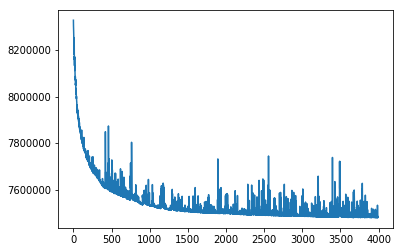

In [26]:
import matplotlib.pyplot as plt
plt.plot(approx1.hist[10:]) 
plt.show()


In [10]:
theta_pymc3[:100]

array([[  1.00116767e-09,   3.87841110e-05,   4.83886708e-08,
          2.20516259e-05,   2.00163353e-02,   9.79922780e-01],
       [  1.00704297e-09,   2.65973878e-07,   3.07167713e-08,
          9.81221040e-01,   1.62846642e-02,   2.49399849e-03],
       [  8.05786118e-01,   3.70753705e-03,   3.35580991e-06,
          1.04238385e-02,   1.46631047e-01,   3.34481039e-02],
       [  1.00123652e-09,   2.36777227e-05,   4.55473262e-08,
          1.09317622e-05,   6.94337656e-03,   9.93021967e-01],
       [  1.00127683e-09,   3.32735889e-05,   4.75236028e-08,
          2.42363853e-05,   7.34559399e-03,   9.92596848e-01],
       [  7.97346950e-01,   1.32749479e-02,   9.83566890e-06,
          9.81628522e-03,   1.46032845e-01,   3.35191355e-02],
       [  1.00715429e-09,   3.17112785e-07,   3.34509854e-08,
          9.67944497e-01,   2.10995159e-02,   1.09556354e-02],
       [  8.06958312e-01,   8.51181679e-03,   8.38874638e-06,
          1.29633329e-02,   1.26647512e-01,   4.49106376e-02],


In [27]:
# get estimated topic for each cell
pymc3_z = theta_pymc3.argmax(axis=1)
# compare estimated cell topics with true cell topics
pd.DataFrame({"celda":celda_z, "pymc3":pymc3_z}).groupby(["pymc3","celda"]).size() 

pymc3  celda
0      1        136
1      2        114
3      4         51
4      3        102
5      5         41
dtype: int64

In [28]:
# get estimated transcriptional state for each gene
pymc3_y = psi_pymc3.argmax(axis=0)
# compare estimated and true gene transcriptional states 
pd.DataFrame({"celda":celda_y, "pymc3":pymc3_y}).groupby(["pymc3","celda"]).size()

pymc3  celda
0      1         92
       2         41
       5        109
1      2          3
       4          6
       6          2
2      1         25
       2        155
       3         17
       4          3
       5          8
3      1        106
       3        188
4      1         19
       2          1
       3          2
       4        222
dtype: int64